In [139]:

import numpy as np
import matplotlib.pyplot as plt

from hospital_model import hospital_model
import random
import simpy
import copy

In [115]:


# generator starts new patient process according to interval distribution
def patient_generator_mkB(env,conf,resu,facilities):
    while True:
        env.process(patient_mkB(env,conf,resu,facilities))
        yield env.timeout(conf["times"][0].rvs())
        #yield env.timeout(random.expovariate(1/20))

# individual patient, keeps track of actual service times for each stage: required time and extra waiting
def patient_mkB(env,conf,resu,facilities):
    # minimum processing times for each stage, using config
    #e = random.expovariate
    #req_times = [e(1/conf['means'][1]),e(1/conf['means'][2]),e(1/conf['means'][3])]
    req_times = [conf['times'][1].rvs(),#prep time
                 conf['times'][2].rvs(),#operation time
                 conf['times'][3].rvs()#recovery time
                 ]
    #req_times = conf["times"]

    flow_times = [env.now, 0, 0, 0, 0] # arrival times at each stage, including release
    resu['patient_flow'].append(flow_times)

    # --- individual patient path through system ---
    # note that patient path logging is also timed, to reduce error in total
    # * if it was logged at the end, active patients would not affect simulation results
    # * some error still remains, from not considering partial process completions at result calculation moment.

    prep = facilities[0].request()
    resu['patient_counts'][0] += 1
    yield prep # wait prep room
    flow_times[1] = env.now # patient taken to a prep room
    resu['patient_counts'][1] += 1

    yield env.timeout(req_times[0])
    op = facilities[1].request()
    resu['util_active'][0] += req_times[0] # prep done, waiting op
    yield op
    facilities[0].release(prep) # op room free, release prep
    resu['patient_counts'][1] -= 1
    resu['patient_counts'][2] += 1
    flow_times[2] = env.now # patient enters operation
    resu['total_active'][0] += flow_times[2] - flow_times[1] # op start - prep start = prep total

    yield env.timeout(req_times[1])
    rec = facilities[2].request()

    resu['util_active'][1] += req_times[1] # op done
    block_start = env.now
    yield rec
    block_end = env.now
    resu["or_time_blocked"]+= block_end - block_start # time waiting for rec bed
    facilities[1].release(op) # op free once rec opens
    resu['patient_counts'][2] -= 1
    resu['patient_counts'][3] += 1
    flow_times[3] = env.now # patient starts recovery
    resu['total_active'][1] += flow_times[3] - flow_times[2] # op total

    yield env.timeout(req_times[2])
    facilities[2].release(rec) # rec done
    resu['patient_counts'][3] -= 1
    resu['patient_counts'][0] -= 1 # reduce total # of patients in system when rec is done
    resu['util_active'][2] += req_times[2] # rec done
    resu['total_active'][2] += req_times[2] # rec does not need to wait, so util% is always 100.
    flow_times[4] = env.now # patient leaves

# result monitor for things the patient doesnt track directly
def monitor_mkB(env,conf,resu,facilities):
    while True:
        snapshot = {
            'time': env.now,
            'patient_counts': copy.deepcopy(resu['patient_counts']), # totals in system at snapshot time
            'queues': [len(facilities[0].queue), len(facilities[1].queue), len(facilities[2].queue)] # queues of each stage.
        }
        resu['snapshots'].append(snapshot)
        yield env.timeout(conf['monitor_interval'])

class hospital_model:

    def __init__(self,conf):
        self.env = simpy.Environment()
        self.conf = conf

        # simulation results
        self.results = {
            'patient_flow': [], # all flow times for each patient: arrival/prep/op/rec/leave
            'patient_counts': [0,0,0,0], # patient count in: total/prep/op/rec
            'total_active': [0,0,0], # total time of prep/op/rec
            'util_active': [0,0,0], # active time of prep/op/rec
            'snapshots': [], # simulation situation at snapshot times, created by monitor process
            'or_time_blocked': 0
        }

        # seed the rng
        random.seed(a=conf['seed']) # doesnt need to check for None, seed() already does

        # create limited resources
        # + request all slack resources to remove them from the useable pool
        self.facilities = []
        self.slack_requests = []
        for i in range(0,len(conf['total'])):
            self.facilities.append(simpy.Resource(self.env,capacity=conf['total'][i]))
            facility_slack = []
            self.slack_requests.append(facility_slack)

        # create always-on processes
        self.env.process(monitor_mkB(self.env,conf,self.results,self.facilities))
        self.env.process(patient_generator_mkB(self.env,conf,self.results,self.facilities))


    # env run for time, also does config check for facilities
    def run_for(self, time):
        # refresh facilities according to config at start of time step:
        for i in range(0,len(self.conf['total'])): # loop each facility type.
            # pop and release previous slack state
            for j in range(0,len(self.slack_requests[i])):
                self.facilities[i].release(self.slack_requests[i].pop())
            # create new slack state
            for j in range(0,self.conf['total'][i] - self.conf['staffed'][i]):
                self.slack_requests[i].append(self.facilities[i].request())
                if (len(self.facilities[i].queue) > 0): # request did not go through immediately, move it to be first in prio
                    self.facilities[i].queue.insert(0,self.facilities[i].queue.pop())
        # continue simulation from current time:
        self.env.run(until= self.env.now + time)

In [117]:
# --- alt. ver of 3-config comparison.
def simulate(samples,rooms,times):
    utilizations = []
    blocked = []
    queue_lenghts = []
    for sample in range(samples):

        conf = {
        'seed': None,
        #'means': [25, 40, 20, 40], # mean times of all stages: next/prep/op/rec
        'total': [5,2,5], # useable + starting slack (unused/offline) capacity for each facility type.
        'staffed': rooms, # useable totals of each identical facility: prep/op/rec
        'monitor_interval': 5, # snapshot interval for non-patient variables, such as queues
        'times':times #distributions for patient times
    }
        conf['seed'] = sample # all three hospital configurations use the same seed, but there is 20 different seeds total.
        conf['total'] = [10,10,10] # increase slack capacity for demo. changes to this conf param dont have effect mid-simulation
        hospital = hospital_model(conf)

        #hospital.run_for(1000)


        # hospital.run_for(1000)

        conf['staffed'] = rooms # change what facilities are staffed
        #print(hospital.env.now)
        hospital.run_for(100)#warm up
        env_time = hospital.env.now #env time after warmup
        #print(env_time)
        #Resetting statsistics
        hospital.results["or_time_blocked"] = 0
        hospital.results["util_active"] = [0,0,0]
        hospital.results["total_active"] = [0,0,0]
        hospital.results["snapshots"]=[]

        hospital.run_for(10000)#actual simulation run
        active_times = hospital.results["util_active"]
        total_times  = hospital.results["total_active"]
        blocked_time = hospital.results["or_time_blocked"]

        total_time = hospital.results["snapshots"][-1]["time"] -env_time #total simulation time,simulation time at the end - warmup time
        sample_q_times = []
        for snapshot in hospital.results["snapshots"]:
            sample_q_times.append(snapshot["queues"][1])
        queue_lenghts.append(np.mean(sample_q_times))
        utilizations.append(np.round(active_times[1]/total_time,5)*100)
        blocked.append(np.round(blocked_time/total_time,3)*100)

    print(f'Statistics for {rooms[0]}p {rooms[2]}r configuration ')
    print(f'MEAN utilization: {np.round(np.mean(utilizations),3)}%')
    print(f'MEAN blocked: {np.round(np.mean(blocked),3)}%')
    print("--------------------------------")

    return utilizations,blocked,queue_lenghts




In [138]:
import scipy
import pandas as pd
#possible arrival times
arrival_exp_25 = scipy.stats.expon(scale=25)
arrival_exp_22_5 = scipy.stats.expon(scale=22.5)
arrival_unif_20_30 = scipy.stats.uniform(20,30)
arrival_unif_20_25 = scipy.stats.uniform(20,25)
#possible prep times
prep_exp = scipy.stats.expon(scale=40)
prep_unif = scipy.stats.uniform(30,50)
#op time
op = scipy.stats.expon(scale=20)
#possible rec times
rec_exp = scipy.stats.expon(scale=40)
rec_unif = scipy.stats.uniform(30,50)

#[rooms,distributions for patient times]
configurations = [
    #4 prep,4 rec
    [[4,1,4],[arrival_exp_22_5,prep_exp,op,rec_exp]],
    [[4,1,4],[arrival_unif_20_30,prep_exp,op,rec_exp]],
    [[4,1,4],[arrival_exp_25,prep_unif,op,rec_unif]],
    [[4,1,4],[arrival_unif_20_30,prep_unif,op,rec_unif]],
    #5 prep,4 rec
    [[5,1,4],[arrival_exp_25,prep_exp,op,rec_exp]],
    [[5,1,4],[arrival_unif_20_30,prep_exp,op,rec_exp]],
    [[5,1,4],[arrival_exp_25,prep_unif,op,rec_unif]],
    [[5,1,4],[arrival_unif_20_30,prep_unif,op,rec_unif]],
]


results = pd.DataFrame(columns=["avg_queue_length","avg_queue_per_sample","config","or_usage"])
for i,conf in enumerate(configurations):

    utilizations,blocked,queue = simulate(samples = 10,rooms=conf[0],times = conf[1])
    results.loc[len(results)] = [np.mean(queue),queue,i,np.mean(utilizations)]



Statistics for 4p 4r configuration 
MEAN utilization: 85.878%
MEAN blocked: 2.72%
--------------------------------
Statistics for 4p 4r configuration 
MEAN utilization: 58.247%
MEAN blocked: 0.25%
--------------------------------
Statistics for 4p 4r configuration 
MEAN utilization: 78.832%
MEAN blocked: 4.9%
--------------------------------
Statistics for 4p 4r configuration 
MEAN utilization: 58.703%
MEAN blocked: 0.55%
--------------------------------
Statistics for 5p 4r configuration 
MEAN utilization: 81.207%
MEAN blocked: 2.43%
--------------------------------
Statistics for 5p 4r configuration 
MEAN utilization: 56.895%
MEAN blocked: 0.29%
--------------------------------
Statistics for 5p 4r configuration 
MEAN utilization: 77.759%
MEAN blocked: 5.75%
--------------------------------
Statistics for 5p 4r configuration 
MEAN utilization: 57.689%
MEAN blocked: 0.35%
--------------------------------


Text(0, 0.5, 'Average or usage')

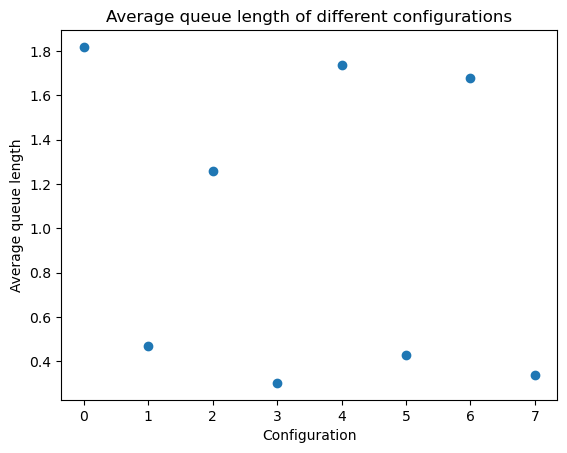

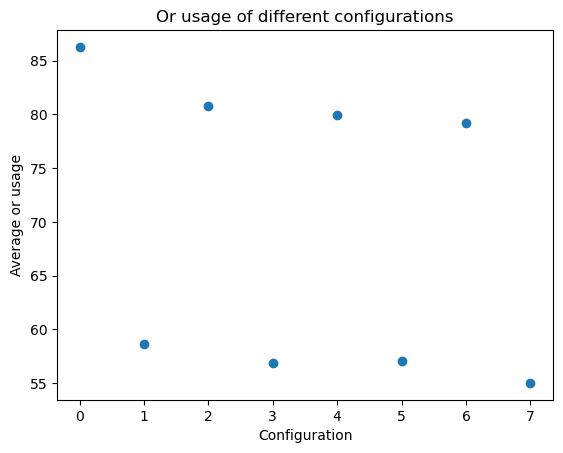

In [129]:
data = pd.DataFrame(columns=["queue","config"])
data["queue"]=results["avg_queue_length"]
data["config"]=results["config"]
data["usage"]=results["or_usage"]
plt.figure(0)
plt.scatter(data["config"],data["queue"])
plt.title("Average queue length of different configurations")
plt.xlabel("Configuration")
plt.ylabel("Average queue length")

plt.figure(1)
plt.scatter(data["config"],data["usage"])
plt.title("Or usage of different configurations")
plt.xlabel("Configuration")
plt.ylabel("Average or usage")

In [135]:
results


,avg_queue_length,avg_queue_per_sample,config,or_usage
0,1.77715,"[1.363, 1.832, 1.8895, 1.863, 1.9325, 1.9625, ...",0,86.4303
1,0.40465,"[0.3915, 0.382, 0.3915, 0.541, 0.34, 0.4575, 0...",1,58.1452
2,1.21190,"[1.7075, 1.067, 1.529, 1.136, 1.147, 1.3135, 0...",2,79.1082
3,0.34400,"[0.2115, 0.292, 0.4165, 0.642, 0.266, 0.373, 0...",3,56.9219
4,1.51520,"[1.3165, 1.54, 1.5635, 1.5925, 1.553, 1.9715, ...",4,75.5497
5,0.43060,"[0.3295, 0.332, 0.5365, 0.627, 0.439, 0.4175, ...",5,57.3947
6,1.63235,"[2.2125, 1.666, 1.1945, 1.339, 1.1395, 1.639, ...",6,79.1890
7,0.33660,"[0.2445, 0.2325, 0.3725, 0.3305, 0.425, 0.328,...",7,56.3105


(array([518., 231., 127.,  59.,  31.,  18.,  11.,   2.,   2.,   1.]),
 array([3.24331077e-03, 1.72746556e+01, 3.45460680e+01, 5.18174803e+01,
        6.90888926e+01, 8.63603049e+01, 1.03631717e+02, 1.20903130e+02,
        1.38174542e+02, 1.55445954e+02, 1.72717367e+02]),
 <BarContainer object of 10 artists>)

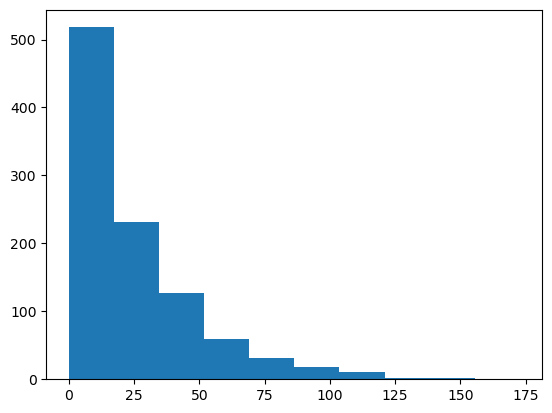

In [172]:
scipy.stats.expon(scale=25).rvs()
random.expovariate(1/25)
res  = []
for i in range(1000):
    res.append(scipy.stats.expon(scale=25).rvs())
plt.hist(res)